# Using an off the shelf detector

In this notebook I show how to use a model from the [official model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). Moreover, we will evaluate its performance on our dataset, which is always the most important thing. Most of this notebook is copy pasted from the [original tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb), so have a look there for reference.

In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tarfile
from tqdm import tqdm
import urllib.request

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import ops as utils_ops

%matplotlib inline

Based on the official tutorial (referenced above) we are goint to create class that takes care of everything from downloading to making inference with the trained model. Our class will allow us to run predictions much faster than with the function provided in the tutorial.

In [49]:
class TrainedDetectionModel:
    def __init__(self, detection_graph, category_index):
        self._build_required_tensors(detection_graph)
        self._detection_graph = detection_graph
        self.category_index = category_index
        
    def _build_required_tensors(self, detection_graph):
        with detection_graph.as_default():
            with tf.Session() as sess:
              # Get handles to input and output tensors
                ops = tf.get_default_graph().get_operations()
                all_tensor_names = {output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks'
                  ]:
                    tensor_name = key + ':0'
                    if tensor_name in all_tensor_names:
                        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                          tensor_name)
                if 'detection_masks' in tensor_dict:
                    # The following processing is only for single image
                    detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                    detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                    real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                    detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                    detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                        detection_masks, detection_boxes, image.shape[0], image.shape[1])
                    detection_masks_reframed = tf.cast(
                        tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                    # Follow the convention by adding back the batch dimension
                    tensor_dict['detection_masks'] = tf.expand_dims(
                        detection_masks_reframed, 0)

                self._image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
                self._tensor_dict = tensor_dict
        
    
    def _retrieve_output_dict(self, image, sess):
        
        output_dict = sess.run(
            self._tensor_dict, feed_dict={self._image_tensor: np.expand_dims(image, 0)})
        
        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]
        
        return output_dict
        
    def single_image_inference(self, image):
        
        with tf.Session(graph=self._detection_graph) as sess:
            output_dict = self._retrieve_output_dict(image, sess)
        return output_dict
    
    def inference_from_generator(self, generator, retrieve_image=False):
        
        with tf.Session(graph=self._detection_graph) as sess:
            for img in generator:         
                output_dict = self._retrieve_output_dict(img, sess)
                if retrieve_image:
                    yield img, output_dict
                else:
                    yield output_dict
                    
                
    @staticmethod
    def maybe_download_and_extract(model_name):
        path_to_frozen_graph = os.path.join(model_name, 'frozen_inference_graph.pb')
        model_file = model_name + '.tar.gz'
        if model_name not in os.listdir() or not os.path.isfile(path_to_frozen_graph):
            url = 'http://download.tensorflow.org/models/object_detection/' + model_file
            print("Downloading: " + url)
            opener = urllib.request.URLopener()
            opener.retrieve(url, model_file)

            tar_file = tarfile.open(model_file)
            for file in tar_file.getmembers():
                file_name = os.path.basename(file.name)
                if 'frozen_inference_graph.pb' in file_name:
                    tar_file.extract(file, os.getcwd())
                    
        return path_to_frozen_graph
                    
    @classmethod
    def from_model_name(cls, model_name, label_map_name):
        path_to_frozen_graph = cls.maybe_download_and_extract(model_name)
        print("Loading frozen graph from: " + path_to_frozen_graph)
        detection_graph = tf.Graph()
        with detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(path_to_frozen_graph, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
        
        path_to_labels = os.path.join('object_detection','data', 'oid_bbox_trainable_label_map.pbtxt')
        category_index = label_map_util.create_category_index_from_labelmap(path_to_labels, use_display_name=True)
        
        return cls(detection_graph, category_index)

with the previous class we can now have a model as follows:

In [50]:
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_lowproposals_oid_2018_01_28'
LABEL_MAP_NAME = 'oid_bbox_trainable_label_map.pbtxt'
model = TrainedDetectionModel.from_model_name(MODEL_NAME, LABEL_MAP_NAME)

Loading frozen graph from: faster_rcnn_inception_resnet_v2_atrous_lowproposals_oid_2018_01_28/frozen_inference_graph.pb


let us now load our data to make some predictions

In [51]:
DATA_DIR = os.path.join('..', 'dataset', 'train', 'Venice-2')
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'gt', 'gt.txt')
IMAGES_DIR = os.path.join(DATA_DIR, 'img1')

In [52]:
img_list = sorted(os.listdir(IMAGES_DIR))

In [53]:
fname = img_list[0]
img = cv2.imread(
    os.path.join(IMAGES_DIR, fname),
    cv2.IMREAD_COLOR
)
img = img[..., ::-1]
img = cv2.resize(img, (960, 540))

**Time for detection!** We will first see how a detection looks like for a random sampled image and compare it with how the ground truth qualitatively.

In [54]:
output_dict = model.single_image_inference(img)

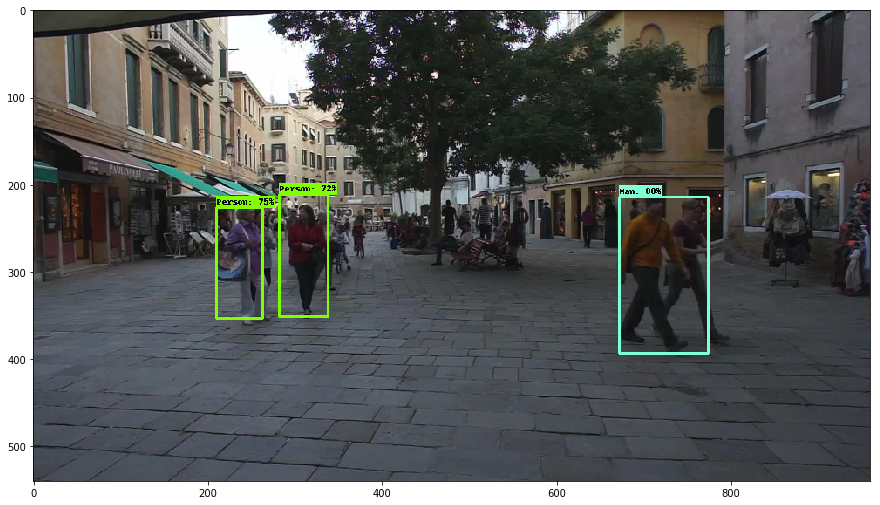

In [55]:
vis_util.visualize_boxes_and_labels_on_image_array(
    img,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    model.category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=3
)
plt.figure(figsize=(15, 15))
plt.imshow(img)

let us make the cool video again; we will modify the function used when we explored the data, so that we can use the provided visualization tool and the previously created class

In [63]:
def make_video_with_bb(img_list, model, fpath='test_video.avi', fps=40, shape=(1920, 1080)):
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    out = cv2.VideoWriter(fpath, fourcc, fps, shape)
    
    def image_generator(img_list):
        msg = "Processing: {}, with shape: {}"
        for fname in img_list:
            img = cv2.imread(os.path.join(IMAGES_DIR, fname), cv2.IMREAD_COLOR)
            print(msg.format(fname, img.shape), end='\r')
            yield img[..., ::-1]
            
    generator = image_generator(img_list)
    
    for img, output_dict in model.inference_from_generator(generator, retrieve_image=True):
        
        vis_util.visualize_boxes_and_labels_on_image_array(
            img,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            model.category_index,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            line_thickness=3
        )
    
        out.write(img)
    out.release()


In [64]:
make_video_with_bb(img_list, model)